# Data Preprocessing
We identified 8 rows with missing values in SES column. We deal with this issue with 2 approaches. One is just to drop the rows with missing values. The other is to replace the missing values with the corresponing values, also known as 'Imputation'. Since we have only 150 data, I assume imputation would help the performance of our model.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set()


In [4]:
df = pd.read_csv('./Data/oasis_longitudinal.csv')

# use first visit data only because of the analysis we're doing
df = df.loc[df['Visit'] == 1]
df = df.reset_index(drop=True)  # reset index after filtering first visit data
df['M/F'] = df['M/F'].replace(['F', 'M'], [0, 1])  # M/F column
df['Group'] = df['Group'].replace(
    ['Converted'], ['Demented'])  # Target variable
df['Group'] = df['Group'].replace(
    ['Demented', 'Nondemented'], [1, 0])  # Target variable
df = df.drop(['MRI ID', 'Visit', 'Hand'], axis=1)  # Drop unnecessary columns


In [5]:
# Check missing values by each column
pd.isnull(df).sum() 
# The column, SES has 8 missing values

Subject ID    0
Group         0
MR Delay      0
M/F           0
Age           0
EDUC          0
SES           8
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

## 5.A Removing rows with missing values

In [8]:
# Dropped the 8 rows with missing values in the column, SES
df_dropna = df.dropna(axis=0, how='any')
pd.isnull(df_dropna).sum()




Subject ID    0
Group         0
MR Delay      0
M/F           0
Age           0
EDUC          0
SES           0
MMSE          0
CDR           0
eTIV          0
nWBV          0
ASF           0
dtype: int64

In [9]:
df_dropna['Group'].value_counts()


0    72
1    70
Name: Group, dtype: int64

## 5.B Imputation
Scikit-learn provides package for imputation [6], but we do it manually. Since the SES is a discrete variable, we use median for the imputation

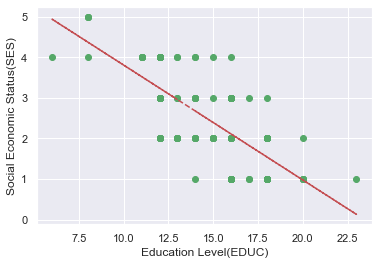

In [10]:
# Draw scatter plot between EDUC and SES
x = df['EDUC']
y = df['SES']

ses_not_null_index = y[~y.isnull()].index
x = x[ses_not_null_index]
y = y[ses_not_null_index]

# Draw trend line in red
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, y, 'go', x, p(x), "r--")
plt.xlabel('Education Level(EDUC)')
plt.ylabel('Social Economic Status(SES)')

plt.show()


In [11]:
df.groupby(['EDUC'])['SES'].median()


EDUC
6     4.0
8     5.0
11    4.0
12    3.0
13    2.0
14    3.0
15    2.0
16    2.0
17    1.0
18    2.0
20    1.0
23    1.0
Name: SES, dtype: float64

In [12]:
df["SES"].fillna(df.groupby("EDUC")["SES"].transform("median"), inplace=True)

# I confirm there're no more missing values and all the 150 data were used.
pd.isnull(df['SES']).value_counts()


False    150
Name: SES, dtype: int64

## 5.C Splitting Train/Validation/Test Sets

In [13]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score


In [14]:
# Dataset with imputation
Y = df['Group'].values  # Target for the model
X = df[['M/F', 'Age', 'EDUC', 'SES', 'MMSE',
        'eTIV', 'nWBV', 'ASF']]  # Features we use

# splitting into three sets
X_trainval, X_test, Y_trainval, Y_test = train_test_split(
    X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval)
X_trainval_scaled = scaler.transform(X_trainval)
X_test_scaled = scaler.transform(X_test)


In [15]:
# Dataset after dropping missing value rows
Y = df_dropna['Group'].values  # Target for the model
X = df_dropna[['M/F', 'Age', 'EDUC', 'SES', 'MMSE',
               'eTIV', 'nWBV', 'ASF']]  # Features we use

# splitting into three sets
X_trainval_dna, X_test_dna, Y_trainval_dna, Y_test_dna = train_test_split(
    X, Y, random_state=0)

# Feature scaling
scaler = MinMaxScaler().fit(X_trainval_dna)
X_trainval_scaled_dna = scaler.transform(X_trainval_dna)
X_test_scaled_dna = scaler.transform(X_test_dna)


## 5.D Cross-validation
We conduct 5-fold cross-validation to figure out the best parameters for each model, Logistic Regression, SVM, Decision Tree, Random Forests, and AdaBoost. Since our performance metric is accuracy, we find the best tuning parameters by accuracy. In the end, we compare the accuracy, recall and AUC for each model.

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
from azureml.core import Run, Dataset, Workspace, Experiment

import os
import sys
import argparse
import joblib

ws = Workspace(subscription_id="9ce8d68a-39d6-47d5-b01d-baf594538731",
               resource_group="PracticeSquadTrain",
               workspace_name="MLSquad"
               )


In [17]:
acc = []  # list to store all performance metric


In [22]:
# Dataset with imputation
best_score=0
kfolds=3 # set the number of folds

for c in [0.1, 1, 10]:
    logRegModel = LogisticRegression(C=c)
    # perform cross-validation
    scores = cross_val_score(logRegModel, X_trainval, Y_trainval, cv=kfolds, scoring='accuracy') # Get recall for each parameter setting
    
    # compute mean cross-validation accuracy
    score = np.mean(scores)
    
    # Find the best parameters and score
    if score > best_score:
        best_score = score
        best_parameters = c

# rebuild a model on the combined training and validation set
SelectedLogRegModel = LogisticRegression(C=best_parameters).fit(X_trainval_scaled, Y_trainval)

test_score = SelectedLogRegModel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedLogRegModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter for regularization (C) is: ", best_parameters)
print("Test accuracy with best C parameter is", test_score)
print("Test recall with the best C parameter is", test_recall)
print("Test AUC with the best C parameter is", test_auc)
m = 'Logistic Regression (w/ imputation)'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

C:\Users\christopher.prattos\Anaconda3\envs\experiment_env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\christopher.prattos\Anaconda3\envs\experiment_env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    ht

Best accuracy on validation set is: 0.7060218112849692
Best parameter for regularization (C) is:  10
Test accuracy with best C parameter is 0.7631578947368421
Test recall with the best C parameter is 0.7
Test AUC with the best C parameter is 0.7666666666666667


C:\Users\christopher.prattos\Anaconda3\envs\experiment_env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\christopher.prattos\Anaconda3\envs\experiment_env\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    ht

# SVM
C: Penalty parameter C of the error term. [0.001, 0.01, 0.1, 1, 10, 100, 1000]

gamma: kernel coefficient. [0.001, 0.01, 0.1, 1, 10, 100, 1000]

kernel: kernel type. ['rbf', 'linear', 'poly', 'sigmoid']

In [30]:
best_score = 0
experiment = Experiment(workspace=ws, name='alz_demi_SVM')
run = experiment.start_logging()
print("Starting experiment:", experiment.name)

# iterate over the values we need to try for the parameter C
for c_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
    # iterate over the values we need to try for the parameter gamma
    for gamma_paramter in [0.001, 0.01, 0.1, 1, 10, 100, 1000]:
        # iterate over the values we need to try for the kernel parameter
        for k_parameter in ['rbf', 'linear', 'poly', 'sigmoid']:
            svmModel = SVC(kernel=k_parameter, C=c_paramter,
                           gamma=gamma_paramter)  # define the model
            # perform cross-validation
            scores = cross_val_score(
                svmModel, X_trainval_scaled, Y_trainval, cv=kfolds, scoring='accuracy')
            # the training set will be split internally into training and cross validation

            # compute mean cross-validation accuracy
            score = np.mean(scores)
            # if we got a better score, store the score and parameters
            if score > best_score:
                best_score = score  # store the score
                best_parameter_c = c_paramter  # store the parameter c
                best_parameter_gamma = gamma_paramter  # store the parameter gamma
                best_parameter_k = k_parameter


# rebuild a model with best parameters to get score
SelectedSVMmodel = SVC(C=best_parameter_c, gamma=best_parameter_gamma,
                       kernel=best_parameter_k).fit(X_trainval_scaled, Y_trainval)

test_score = SelectedSVMmodel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedSVMmodel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on cross validation set is:", best_score)
print("Best parameter for c is: ", best_parameter_c)
print("Best parameter for gamma is: ", best_parameter_gamma)
print("Best parameter for kernel is: ", best_parameter_k)
print("Test accuracy with the best parameters is", test_score)
print("Test recall with the best parameters is", test_recall)
print("Test recall with the best parameter is", test_auc)

m = 'SVM'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])

os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record

model_file = 'outputs/demi_alz_svm.pkl'
joblib.dump(value=SelectedSVMmodel, filename=model_file)

run.complete()

# Register the model
run.register_model(model_path=model_file, model_name='ALZ-DEMI-model',
                   tags={'Model Type': 'SVM'})

print('Model trained and registered.')


Starting experiment: alz_demi_SVM
Best accuracy on cross validation set is: 0.7678994784257943
Best parameter for c is:  10
Best parameter for gamma is:  0.1
Best parameter for kernel is:  rbf
Test accuracy with the best parameters is 0.8157894736842105
Test recall with the best parameters is 0.7
Test recall with the best parameter is 0.8222222222222222
Model trained and registered.


# 6.D Decision Tree
Maximum depth. [1, 2, ..., 8]

8 is the number of features

In [31]:
best_score = 0

experiment = Experiment(workspace=ws, name='alz_demi_DT')
run = experiment.start_logging()
print("Starting experiment:", experiment.name)

for md in range(1, 9):  # iterate different maximum depth values
    # train the model
    treeModel = DecisionTreeClassifier(
        random_state=0, max_depth=md, criterion='gini')
    # perform cross-validation
    scores = cross_val_score(treeModel, X_trainval_scaled,
                             Y_trainval, cv=kfolds, scoring='accuracy')

    # compute mean cross-validation accuracy
    score = np.mean(scores)

    # if we got a better score, store the score and parameters
    if score > best_score:
        best_score = score
        best_parameter = md

# Rebuild a model on the combined training and validation set
SelectedDTModel = DecisionTreeClassifier(
    max_depth=best_parameter).fit(X_trainval_scaled, Y_trainval)

test_score = SelectedDTModel.score(X_test_scaled, Y_test)
PredictedOutput = SelectedDTModel.predict(X_test_scaled)
test_recall = recall_score(Y_test, PredictedOutput, pos_label=1)
fpr, tpr, thresholds = roc_curve(Y_test, PredictedOutput, pos_label=1)
test_auc = auc(fpr, tpr)
print("Best accuracy on validation set is:", best_score)
print("Best parameter for the maximum depth is: ", best_parameter)
print("Test accuracy with best parameter is ", test_score)
print("Test recall with best parameters is ", test_recall)
print("Test AUC with the best parameter is ", test_auc)

m = 'Decision Tree'
acc.append([m, test_score, test_recall, test_auc, fpr, tpr, thresholds])


os.makedirs('outputs', exist_ok=True)
# note file saved in the outputs folder is automatically uploaded into experiment record

model_file = 'outputs/demi_alz_DT.pkl'
joblib.dump(value=SelectedDTModel, filename=model_file)

run.complete()

# Register the model
run.register_model(model_path=model_file, model_name='ALZ-DEMIDT-model',
                   tags={'Model Type': 'Decision Tree'})

print('Model trained and registered.')


Starting experiment: alz_demi_DT
Best accuracy on validation set is: 0.7769084874348033
Best parameter for the maximum depth is:  1
Test accuracy with best parameter is  0.8157894736842105
Test recall with best parameters is  0.65
Test AUC with the best parameter is  0.825
Model trained and registered.


In [32]:
print("Feature importance: ")
np.array([X.columns.values.tolist(), list(
    SelectedDTModel.feature_importances_)]).T


Feature importance: 


array([['M/F', '0.0'],
       ['Age', '0.0'],
       ['EDUC', '0.0'],
       ['SES', '0.0'],
       ['MMSE', '1.0'],
       ['eTIV', '0.0'],
       ['nWBV', '0.0'],
       ['ASF', '0.0']], dtype='<U4')